In [1]:
import pickle
import pandas as pd
import sys
import numpy as np

In [3]:
sys.path.append("../../code/")
sys.path.append("../code/")


from common_functions import tableau20blind, format_axes, latexify
from regional_average_contribution import contribution

In [4]:
out_overall = pickle.load(open('../../data/input/all_regions.pkl', 'r'))

In [5]:
mf_pred = pickle.load(open('../data/mf_pred_subset_homes.pkl','r'))
knn_results = pickle.load(open('../data/knn_pred_subset_homes.pkl','r'))

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
thresholds = {'fridge':10,'hvac':100,'dw':0.5,'mw':0.5,'oven':0.5,'wm':0.5}

In [9]:
def compute_rmse_fraction(appliance, pred_df):
    region = "Austin"
    df = out_overall[region]
    #pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    
    if appliance=="hvac":
        start, stop=5,11
    else:
        start, stop=1,13
    aggregate_df = df.ix[pred_df.index][['aggregate_%d' %month for month in range(start, stop)]]

    aggregate_df.columns = gt_df.columns
    
    # Ignoring homes which have some errors
    if appliance in thresholds:
        a = gt_df[gt_df<thresholds[appliance]].sum(axis=1)
        homes_ignore = a[a>0].index
        gt_df_index = [x for x in gt_df.index if x not in homes_ignore]
        gt_df = gt_df.ix[gt_df_index]
    
    a=(aggregate_df<300).sum(axis=1)
    homes_agrgegate_ignore = a[a>0]
    gt_df_index = [x for x in gt_df.index if x not in homes_agrgegate_ignore]
    gt_df = gt_df.ix[gt_df_index]
    
    
    gt_fraction = gt_df.div(aggregate_df)*100
    pred_fraction = pred_df.div(aggregate_df)*100
    
    pred_fraction = pred_fraction.dropna()
    gt_fraction = gt_fraction.dropna()
    common_index = np.intersect1d(gt_fraction.index, pred_fraction.index)
    pred_fraction = pred_fraction.ix[common_index]
    gt_fraction = gt_fraction.ix[common_index]
    
    #print (gt_fraction>1000).sum().sum()
    #e = (pred_fraction>1000).sum(axis=1)
    #print e[e>0]

    rms = np.sqrt(mean_squared_error(pred_fraction,gt_fraction))
    return rms

In [9]:
def compute_rmse_fraction(appliance, pred_df):
    region = "Austin"
    df = out_overall[region]
    #pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    if appliance=="hvac":
        start, stop=5,11
    else:
        start, stop=1,13
    aggregate_df = df.ix[pred_df.index][['aggregate_%d' %month for month in range(start, stop)]]
    
    # Ignoring homes which have some errors
    if appliance in thresholds:
        a = gt_df[gt_df<thresholds[appliance]].sum(axis=1)
        homes_ignore = a[a>0].index
        gt_df_index = [x for x in gt_df.index if x not in homes_ignore]
        gt_df = gt_df.ix[gt_df_index]
    
    a=(aggregate_df<300).sum(axis=1)
    homes_agrgegate_ignore = a[a>0]
    gt_df_index = [x for x in gt_df.index if x not in homes_agrgegate_ignore]
    gt_df = gt_df.ix[gt_df_index]
    

    aggregate_df.columns = gt_df.columns
    gt_fraction = gt_df.div(aggregate_df)*100
    pred_fraction = pred_df.div(aggregate_df)*100
    
    pred_df = pred_df.dropna()
    gt_df = gt_df.dropna()
    common_index = np.intersect1d(gt_df.index, pred_df.index)
    pred_df = pred_df.ix[common_index]
    gt_df = gt_df.ix[common_index]


    rms = np.sqrt(mean_squared_error(pred_df,gt_df))
    return rms

In [10]:
result = {'MF-105 homes, feature':{},'MF-516 homes':{},'MF-516 homes, feature':{},'KNN':{},'MF-105 homes':{},'FHMM':{},'LBM':{},"RA":{}}
#result = {'MF':{},'KNN':{},'FHMM':{},'LBM':{},"RA":{}}

## Computing for KNN

In [11]:
for appliance, appliance_df in knn_results.iteritems():
    
    pred_df = appliance_df
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    pred_df.columns = [appliance+"_"+str(x) for x in range(start, stop)]
    print pred_df.isnull().sum().sum(), appliance
    rmse_fraction = compute_rmse_fraction(appliance, pred_df)
    

    #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
    result['KNN'][appliance]=rmse_fraction

0 hvac
0 wm
0 fridge
0 mw
0 oven
0 dw


In [12]:
pred_df.median().mean()

8.169439936742776

In [13]:
best_combination = {}
for appliance, appliance_struct in mf_pred.iteritems():
    print appliance
    best_appliance=1000
    for latent_factors, appliance_df in appliance_struct['None'].iteritems():
        try:
            region = "Austin"
            df = out_overall[region]
            pred_df = mf_pred[appliance]['None'][latent_factors]
            rms = compute_rmse_fraction(appliance, pred_df)

            if rms<best_appliance:
                best_appliance=rms
                best_combination[appliance]=('None', latent_factors, rms)
        except Exception, e:
            print e
    result['MF-105 homes'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 8, 11.726771530318491), 'wm': ('None', 1, 0.48608145514962425), 'fridge': ('None', 3, 3.7386486226163234), 'mw': ('None', 3, 0.62327295992340415), 'oven': ('None', 1, 1.0888817822127712), 'dw': ('None', 7, 1.0269521688013372)}


In [17]:
best_combination = {}
mf_pred_full = pickle.load(open('../data/mf_pred_all_homes.pkl','r'))

for appliance, appliance_struct in mf_pred_full.iteritems():
    print appliance
    best_appliance=1000
    for latent_factors, appliance_df in appliance_struct['None'].iteritems():
        try:
            region = "Austin"
            df = out_overall[region]
            pred_df = mf_pred_full[appliance]['None'][latent_factors]
            pdcopy = pred_df.copy()
            pred_df = pred_df.ix[mf_pred[appliance]['None'][latent_factors].index]
            rms = compute_rmse_fraction(appliance, pred_df)

            if rms<best_appliance:
                best_appliance=rms
                best_combination[appliance]=('None', latent_factors, rms)
        except Exception, e:
            print e
    result['MF-516 homes'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 8, 11.726771530318491), 'wm': ('None', 1, 0.48608145514962425), 'fridge': ('None', 3, 3.7386486226163234), 'mw': ('None', 3, 0.62327295992340415), 'oven': ('None', 1, 1.0888817822127712), 'dw': ('None', 7, 1.0269521688013372)}


In [19]:
pred_df.describe()

,dw_1,dw_2,dw_3,dw_4,dw_5,dw_6,dw_7,dw_8,dw_9,dw_10,dw_11,dw_12
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,12.169383,10.831409,11.170653,10.695790,10.494531,10.182010,9.881152,9.770499,10.284919,10.468115,10.642150,11.555231
std,7.929086,7.489090,8.305626,8.026819,7.648642,8.433778,7.438281,7.067330,6.785032,7.012353,6.970627,8.872568
min,2.255196,1.914210,2.353613,1.924769,1.808461,2.010669,1.857449,1.743961,1.645882,1.692829,1.814516,2.021505
25%,7.152304,6.456247,6.368408,5.974809,5.890456,5.902722,5.758194,5.608049,5.999232,6.284830,6.361626,6.325349
50%,9.426303,8.936610,9.421339,8.130770,8.473115,7.789584,7.385081,7.877597,8.444760,8.222845,8.432047,9.592737
75%,14.124195,12.217910,12.667689,12.103517,12.038230,11.513118,11.126772,10.766045,11.787584,11.866559,12.507610,13.105073
max,46.310546,43.985913,50.152392,48.347564,45.834026,58.299890,46.244636,39.288605,38.436275,37.714881,37.831637,58.892021


In [24]:
mf_pred['hvac']['None'][1].head()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,221.993839,436.243879,637.848849,692.471808,489.021022,244.141367
59,191.917861,377.218334,551.096355,598.051122,422.806829,211.407143
94,67.422739,132.547763,193.764976,210.422584,148.579064,74.263260
101,107.527845,211.439812,309.115172,335.709212,237.031295,118.455750
222,483.421523,951.042682,1393.539247,1513.798159,1067.724064,531.708026


In [27]:
mf_pred_full['hvac']['None'][1].head(20)

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
26,221.993839,436.243879,637.848849,692.471808,489.021022,244.141367
59,191.917861,377.218334,551.096355,598.051122,422.806829,211.407143
77,191.901703,377.352084,551.879991,599.295403,423.198359,211.515511
86,231.327714,454.681305,664.177712,721.070430,509.231026,254.588275
93,178.427370,350.767673,512.716780,556.676238,393.115398,196.527793
94,67.422739,132.547763,193.764976,210.422584,148.579064,74.263260
101,107.527845,211.439812,309.115172,335.709212,237.031295,118.455750
114,186.930846,367.299856,536.861571,583.025964,411.776877,205.827719
115,61.194311,120.305695,175.871634,191.000376,134.863896,67.418029
121,187.695494,369.543424,540.020567,586.552188,413.954628,206.787908


In [42]:
best_combination = {}
for appliance, appliance_struct in mf_pred.iteritems():
    print appliance
    best_appliance=1000
    for appliance_feature, appliance_feature_struct in appliance_struct.iteritems():
        for latent_factors, appliance_df in appliance_struct[appliance_feature].iteritems():
            try:
                region = "Austin"
                df = out_overall[region]
                pred_df = mf_pred[appliance][appliance_feature][latent_factors]
                if 8419 in pred_df.index:
                    pass
                    #pred_df = pred_df.drop(8419)
                
                rms = compute_rmse_fraction(appliance, pred_df)

                if rms<best_appliance:

                    best_appliance=rms
                    best_combination[appliance]=(appliance_feature, latent_factors, rms)
            except:
                pass
    result['MF-105 homes, feature'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 8, 11.726771530318491), 'wm': ('area_rooms', 2, 0.48588674916520552), 'fridge': ('occ_area', 6, 3.5439775801215556), 'mw': ('area', 3, 0.61803497791511286), 'oven': ('occ_area', 2, 1.0210719937671571), 'dw': ('occ', 2, 0.93710343672086849)}


In [43]:
best_combination = {}
for appliance, appliance_struct in mf_pred_full.iteritems():
    print appliance
    best_appliance=1000
    for appliance_feature, appliance_feature_struct in appliance_struct.iteritems():
        for latent_factors, appliance_df in appliance_struct[appliance_feature].iteritems():
            try:
                region = "Austin"
                df = out_overall[region]
                pred_df = mf_pred_full[appliance][appliance_feature][latent_factors]
                pred_df = pred_df.ix[mf_pred[appliance][appliance_feature][latent_factors].index]
                
                rms = compute_rmse_fraction(appliance, pred_df)

                if rms<best_appliance:

                    best_appliance=rms
                    best_combination[appliance]=(appliance_feature, latent_factors, rms)
            except:
                pass
    result['MF-516 homes, feature'][appliance]=best_appliance
            
print best_combination

hvac
wm
fridge
mw
oven
dw
{'hvac': ('None', 8, 11.726771530318491), 'wm': ('area_rooms', 2, 0.48588674916520552), 'fridge': ('occ', 6, 3.5998891080357986), 'mw': ('occ', 2, 0.61234072872378198), 'oven': ('occ_area', 2, 1.0210719937671571), 'dw': ('occ_area', 2, 0.93735010995377077)}


In [44]:
def get_fhmm(appliance):
    count = 0
    for test_region in ["Austin"]:
        out = {}
        test_df = out_overall[test_region]
        test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
        
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        out[appliance] = {}
        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        for test_home in test_df_appliance.index:
            try:
                #print test_home
                pred_df = pd.read_csv("/Users/nipunbatra/wiki-15min-fhmm-out/%s_%d.csv" %(test_region, test_home),index_col=0)
                pred_df_appliance = pred_df[appliance].ix[start:stop-1]
                gt_df_appliance = test_df.ix[test_home][['%s_%d' %(appliance, month) for month in range(start, stop)]]
                gt_df_appliance.index = pred_df_appliance.index
                error = ((pred_df_appliance-gt_df_appliance).abs()*100/gt_df_appliance)
                #error[error>100]=100
                #acc = 100-error
                out[appliance][test_home]=pred_df_appliance
            except:
                pass
    return pd.DataFrame(out[appliance]).T

In [45]:
lbm_pred_df = pickle.load(open('../data/lbm_15_Austin.pkl'))
def get_lbm(appliance, region):
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_df = out_overall[region]
    test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
    pred_df = lbm_pred_df[['%s_%d' %(appliance,month) for month in range(start,stop)]]

    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
    gt_df.columns = pred_df.columns
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    return pred_df

In [46]:
for appliance in knn_results.keys():
    try:
    
        pred_df = get_fhmm(appliance)
        pred_df.columns = [appliance+"_"+str(x) for x in pred_df.columns]
        rmse_fraction = compute_rmse_fraction(appliance, pred_df)


        #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
        result['FHMM'][appliance]=rmse_fraction
        pred_df = get_lbm(appliance,'Austin')
        #pred_df.columns = [appliance+"_"+str(x) for x in pred_df.columns]
        rmse_fraction = compute_rmse_fraction(appliance, pred_df)


        #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
        result['LBM'][appliance]=rmse_fraction

        pred_df = get_regional_average(appliance,'Austin')
        #pred_df.columns = [appliance+"_"+str(x) for x in pred_df.columns]
        rmse_fraction = compute_rmse_fraction(appliance, pred_df)


        #rms = np.sqrt(mean_squared_error(gt_df, pred_df))
        result['RA'][appliance]=rmse_fraction
    except:
        pass

In [47]:
def get_regional_average(appliance, test_region='Austin'):
    try:
        contri_austin_appliance = contribution[test_region]['Cooling'][appliance]
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        test_df = out_overall[test_region]
        test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]

        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        pred_df = test_df_appliance[['aggregate_%d' %month for month in range(start, stop)]]*contri_austin_appliance
        pred_df.columns = ['%s_%d' %(appliance, month) for month in range(start, stop)]
        gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
        gt_df.columns = pred_df.columns
        error = (gt_df-pred_df).abs().div(gt_df).mul(100)
        return pred_df
    except:
        return np.NaN

In [72]:
pd.set_option('precision',5)

In [73]:
results_df = pd.DataFrame(result)

In [74]:
best_combination

{'dw': ('occ_area', 2, 0.93735010995377077),
 'fridge': ('occ', 6, 3.5998891080357986),
 'hvac': ('None', 8, 11.726771530318491),
 'mw': ('occ', 2, 0.61234072872378198),
 'oven': ('occ_area', 2, 1.0210719937671571),
 'wm': ('area_rooms', 2, 0.48588674916520552)}

In [75]:
map_appliance = {'fridge':'Fridge','dw':'Dish washer','mw':'Microwave','hvac':'HVAC','oven':'Oven','wm':'Washing machine'}

In [76]:
#results_df[results_df>100]=100
#results_df=results_df.fillna(100)
results_df.index = [map_appliance[appliance] for appliance in results_df.index]
#results_df.plot(kind='bar', colors=tableau20blind[::2])

In [77]:
results_df = results_df.ix[['HVAC','Fridge','Oven','Dish washer','Washing machine','Microwave']]

In [78]:
results_df_complete = results_df.copy()
results_df_complete.to_latex("../results/105-homes-complete.txt")

In [79]:
results_df_complete

,FHMM,KNN,LBM,MF-105 homes,"MF-105 homes, feature",MF-516 homes,"MF-516 homes, feature",RA
HVAC,15.25937,12.61822,29.37438,11.72677,11.72677,11.72677,11.72677,17.44209
Fridge,4.48070,4.37191,2.68618,3.73865,3.54398,3.73865,3.59989,4.61885
Oven,34.08839,1.07158,3.83552,1.08888,1.02107,1.08888,1.02107,NaN
Dish washer,12.99469,1.05495,1.74313,1.02695,0.93710,1.02695,0.93735,1.21552
Washing machine,3.97675,0.50354,13.28896,0.48608,0.48589,0.48608,0.48589,0.70509
Microwave,6.31778,0.87106,1.00778,0.62327,0.61803,0.62327,0.61234,NaN


In [70]:
!cat ../results/105-homes-complete.txt

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   FHMM &    KNN &    LBM &  MF-105 homes &  MF-105 homes, feature &  MF-516 homes &  MF-516 homes, feature &     RA \\
\midrule
HVAC            &  15.26 &  12.62 &  29.37 &         11.73 &                  11.73 &         11.73 &                  11.73 &  17.44 \\
Fridge          &   4.48 &   4.37 &   2.69 &          3.74 &                   3.54 &          3.74 &                   3.60 &   4.62 \\
Oven            &  34.09 &   1.07 &   3.84 &          1.09 &                   1.02 &          1.09 &                   1.02 &    NaN \\
Dish washer     &  12.99 &   1.05 &   1.74 &          1.03 &                   0.94 &          1.03 &                   0.94 &   1.22 \\
Washing machine &   3.98 &   0.50 &  13.29 &          0.49 &                   0.49 &          0.49 &                   0.49 &   0.71 \\
Microwave       &   6.32 &   0.87 &   1.01 &          0.62 &                   0.62 &          0.62 &                   0.61 &    NaN \\
\bottomru

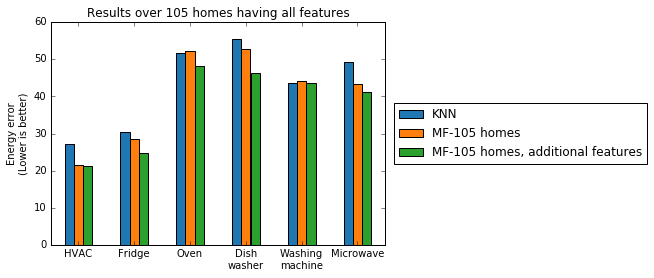

In [93]:
import matplotlib.pyplot as plt
results_df.plot(kind='bar',rot=0, colors=tableau20blind[::2])
lgd = plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5))
plt.ylabel("Energy error\n(Lower is better)");
plt.title("Results over 105 homes having all features")
plt.savefig("../results/subset.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../results/subset.png",bbox_extra_artists=(lgd,), bbox_inches='tight')

Comparing MF with and without homes containing those features

In [23]:
best_combination

{'dw': ('occ', 1, 47.696584280069516),
 'fridge': ('occ_area', 2, 24.91311995551921),
 'hvac': ('rooms', 8, 21.29756141099046),
 'mw': ('occ', 2, 41.60195238757644),
 'oven': ('area_rooms', 8, 48.164684764512515),
 'wm': ('occ_rooms', 3, 43.7072363087808)}

In [31]:
pd.DataFrame(results)

,KNN,MF
dw,55.305178,47.696584
fridge,30.453563,24.913120
hvac,27.268441,21.297561
mw,49.199756,41.601952
oven,51.708601,48.164685
wm,43.735111,43.707236


In [100]:
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    mf_best = mf_pred[appliance][best_combination[appliance][0]][best_combination[appliance][1]]
    knn_best = knn_results[appliance]
    mf_best.columns = knn_best.columns
    common_index = np.intersect1d(mf_best.index, knn_best.index)
    mf_best = mf_best.ix[common_index]
    knn_best = knn_best.ix[common_index]
    knn_best_copy = knn_best.copy()
    mf_best_copy = mf_best.copy()
    max_two = (mf_best_copy.where(mf_best_copy > knn_best_copy, knn_best_copy).fillna(mf_best_copy))
    print appliance,100*((-mf_best+knn_best)/max_two).unstack().std()

fridge 57.3978457853
hvac 55.0774075892
dw 51.1713352881
mw 57.3493816955
wm 53.9492074301
oven 55.2763277251


In [ ]:
Calculating win/loss

In [97]:
o = {}
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    print appliance
    mf_best_pred = mf_pred[appliance][best_combination[appliance][0]][best_combination[appliance][1]]
    knn_best_pred = knn_results[appliance]
    mf_best_pred.columns = knn_best_pred.columns
    common_index = np.intersect1d(mf_best_pred.index, knn_best_pred.index)
    region = "Austin"
    df = out_overall[region]
    pred_df = mf_pred[appliance][appliance_feature][latent_factors]
    gt_df = df[pred_df.columns].ix[pred_df.index]
    mf_best_pred = mf_best_pred.ix[common_index]
    knn_best_pred = knn_best_pred.ix[common_index]
    error_mf = (gt_df-mf_best_pred).abs()
    error_knn = (gt_df-knn_best_pred).abs()
    win = (error_knn>error_mf).sum().sum()
    loss = (error_knn<error_mf).sum().sum()
   
    o[appliance]={'win':win, "loss":loss, "win/loss":win*1./loss,"win/(win_loss)":win*1./(win+loss)} 

fridge
hvac
dw
mw
wm
oven


In [98]:
pd.DataFrame(o).T

,loss,win,win/(win_loss),win/loss
dw,288,408,0.586207,1.416667
fridge,423,393,0.481618,0.929078
hvac,277,293,0.514035,1.057762
mw,249,315,0.558511,1.265060
oven,179,181,0.502778,1.011173
wm,358,338,0.485632,0.944134


In [92]:
knn_best_pred.columns, mf_best_pred.columns

(Index([u'hvac_5', u'hvac_6', u'hvac_7', u'hvac_8', u'hvac_9', u'hvac_10'], dtype='object'),
 Index([u'hvac_5', u'hvac_6', u'hvac_7', u'hvac_8', u'hvac_9', u'hvac_10'], dtype='object'))

In [118]:
knn_best.median().mean()

51.70860070119945

In [119]:
appliance

'oven'

In [112]:
a=(gt_df>10).sum(axis=1)
a[a<12]

59       0
457     11
499     11
954     11
2907    11
3510    10
3893     0
4856    11
5718    11
8419     0
dtype: int64